![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   

# import

In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

import pandas_profiling
from pandas_profiling import ProfileReport

/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [34]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [35]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [36]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [37]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [38]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [39]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [40]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [41]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [42]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [43]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [45]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
18592,id_197,Athens,"['Mediterranean', 'Greek', 'Vegetarian Friendl...",198.0,$$ - $$$,329.0,"[['Strange restaurant !!!!!!!!!!!!', 'Alternat...",/Restaurant_Review-g189400-d7134440-Reviews-Se...,d7134440,1,4.0
5660,id_5660,Geneva,"['Italian', 'French']",1092.0,NaN,2.0,[['Good food served express in a lovely ambie....,/Restaurant_Review-g188057-d10278295-Reviews-C...,d10278295,0,0.0
2222,id_2222,Luxembourg,"['American', 'Bar', 'Pub']",356.0,$$ - $$$,223.0,"[['Good but', 'Sports Bar Come Children’s Play...",/Restaurant_Review-g190356-d743872-Reviews-May...,d743872,0,0.0
42243,id_2203,Barcelona,"['Cafe', 'Spanish', 'Contemporary', 'Gluten Fr...",2204.0,$$ - $$$,56.0,"[['Good drinks, chill vibes, no music', 'Nice ...",/Restaurant_Review-g187497-d7760566-Reviews-Go...,d7760566,1,4.5
10953,id_4293,Rome,"['Brew Pub', 'Fast Food', 'Pub', 'Street Food']",4294.0,$,14.0,"[['Excellent chips quality!'], ['07/22/2016']]",/Restaurant_Review-g187791-d10595133-Reviews-O...,d10595133,1,5.0


## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [46]:
#Обработка Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [47]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
data['Number of Reviews'].fillna(0, inplace=True)

In [48]:
# Обработка 'Price Range'
data['Price_Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')

In [49]:
#Заменим диапазоны значения стоимости на ряд последовательных чисел 
data['Price Range'] = data['Price Range'].astype(str).apply(lambda x: None if x.strip() == '' else x)
data['Price Range'] = data['Price Range'].astype(str).apply(lambda x: x.replace("nan", '0').replace("$$ - $$$", '2').replace('$$$$', '3').replace("$", '1'))

In [50]:
# Обработка Cuisine Style
data['Cuisine_Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')

In [51]:
# Заменим в Cuisine Style пропуски на Other
data['Cuisine Style'].fillna('Other', inplace=True)

In [52]:
data['Cuisine Style'] = data['Cuisine Style'].astype(str).apply(lambda x: None if x.strip() == '' else x)
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: x.replace("['", '').replace("', '", ', ').replace("']", ''))

In [53]:
# Обработка Reviews
data['Reviews'] = data['Reviews'].astype(str).apply(lambda x: None if x.strip() == '' else x)
data['Reviews'] = data['Reviews'].apply(lambda x: x.replace('[', '').replace(']', '').replace("'", ''))
data['Reviews'].fillna('|', inplace=True)

In [54]:
# Посмотрим, что у нас в итоге получилось
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Price_Range_isNAN,Cuisine_Style_isNAN
0,id_0,Paris,"Bar, Pub",12963.0,2,4.0,",",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,0,0
1,id_1,Helsinki,"European, Scandinavian, Gluten Free Options, V...",106.0,2,97.0,"Very good reviews!, Fine dining in Hakaniemi, ...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,0,0
2,id_2,Edinburgh,Vegetarian Friendly,810.0,2,28.0,"Better than the Links, Ivy Black, 12/28/2017, ...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,0,0
3,id_3,London,"Italian, Mediterranean, European, Vegetarian F...",1669.0,3,202.0,"Most exquisite, Delicious and authentic, 12/06...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0,0,0
4,id_4,Bratislava,"Italian, Mediterranean, European, Seafood, Veg...",37.0,3,162.0,"Always the best in bratislava, Very good but p...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0,0,0


# EDA

In [25]:
profile = ProfileReport(data)
profile

Обнаружена высокая корреляция между признаками Rating и sample, что не несет никакой полезной информации. Много уникальных значений у следующих признаков: Cuisine_Style, ID_TA, Restaurant_id, Reviews, URL_TA, что понятно и без анализа. ID_TA, Restaurant_id, URL_TA я исключу из модели. EDA анализ проводился при помощи библиотеки pandas-profiling. Для просмотра ее необходимо установить или смотреть в Kaggle. Хотел с помощью ее съкономить время, но результатом не доволен, либо плохо в ней разобрался.

### 2. Обработка признаков

In [55]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=['City', 'Price Range'], dummy_na=True)

In [56]:
#Количество кухонь в ресторане
data['Cuisine quantity'] = data['Cuisine Style'].apply(lambda x: len(x.split(',')))

In [58]:
#Количество ресторанов у которых более 3 кухонь
data['Cuisine_3'] = data['Cuisine quantity']>3

In [59]:
#Количество ресторанов у которых ранг выше среднего
data['Ranking_mean'] = data['Ranking']>data['Ranking'].mean()

In [60]:
#Количество ресторанов у которых количество отзывов выше среднего
data['Number of Reviews_mean'] = data['Number of Reviews']>data['Number of Reviews'].mean()

In [61]:
data.head(5)

,Restaurant_id,Cuisine Style,Ranking,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,...,City_nan,Price Range_0,Price Range_1,Price Range_2,Price Range_3,Price Range_nan,Cuisine quantity,Cuisine_3,Ranking_mean,Number of Reviews_mean
0,id_0,"Bar, Pub",12963.0,4.0,",",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,...,0,0,0,1,0,0,2,False,True,False
1,id_1,"European, Scandinavian, Gluten Free Options, V...",106.0,97.0,"Very good reviews!, Fine dining in Hakaniemi, ...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,...,0,0,0,1,0,0,5,True,False,False
2,id_2,Vegetarian Friendly,810.0,28.0,"Better than the Links, Ivy Black, 12/28/2017, ...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,...,0,0,0,1,0,0,1,False,False,False
3,id_3,"Italian, Mediterranean, European, Vegetarian F...",1669.0,202.0,"Most exquisite, Delicious and authentic, 12/06...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0,...,0,0,0,0,1,0,5,True,False,True
4,id_4,"Italian, Mediterranean, European, Seafood, Veg...",37.0,162.0,"Always the best in bratislava, Very good but p...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0,...,0,0,0,0,1,0,6,True,False,True


### Посмотрим распределение признака

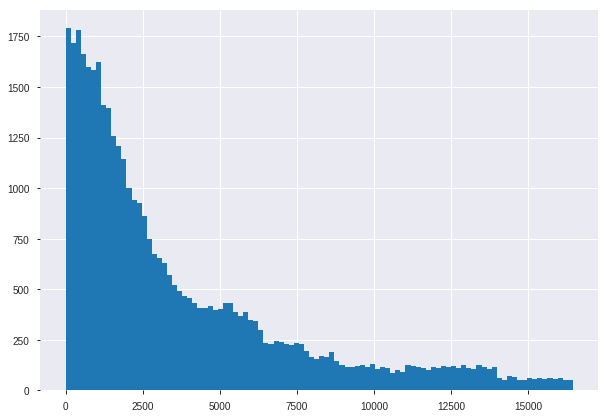

In [62]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

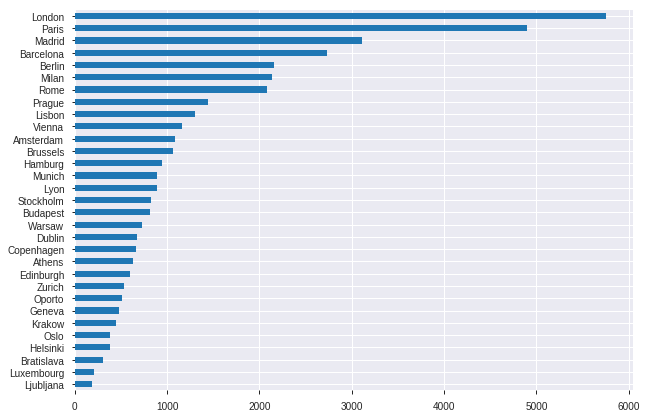

In [63]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

Посмотрим, как изменится распределение в большом городе

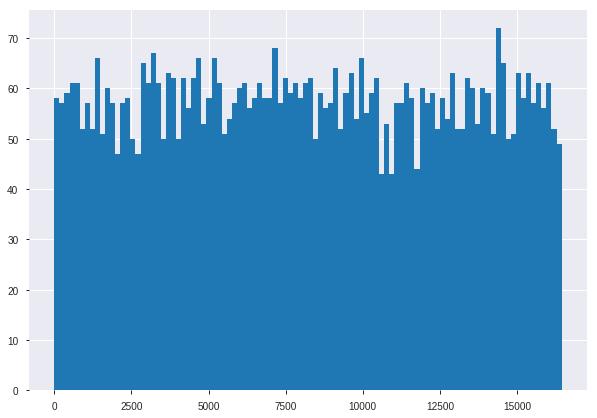

In [64]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

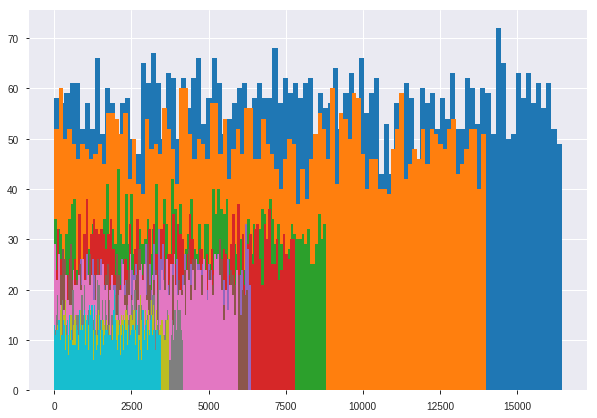

In [65]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.


### Посмотрим распределение целевой переменной

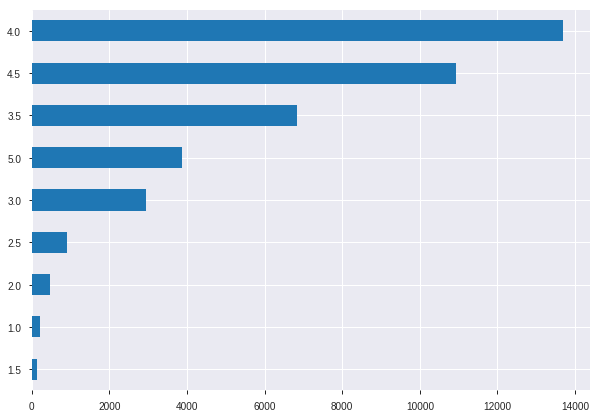

In [66]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

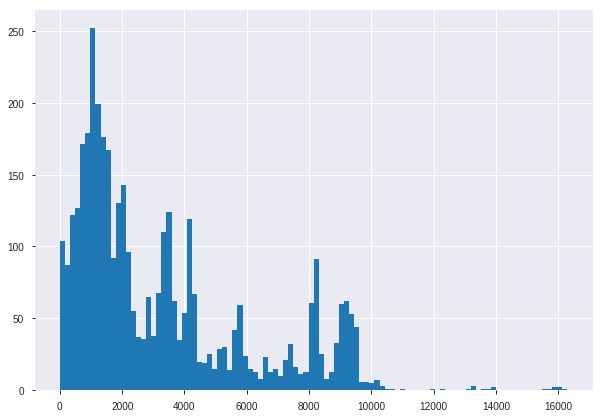

In [67]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

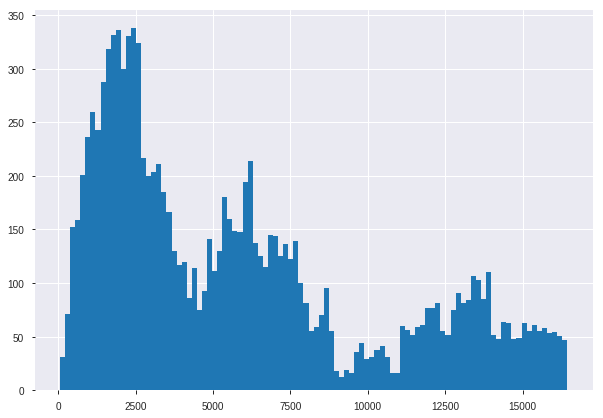

In [68]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

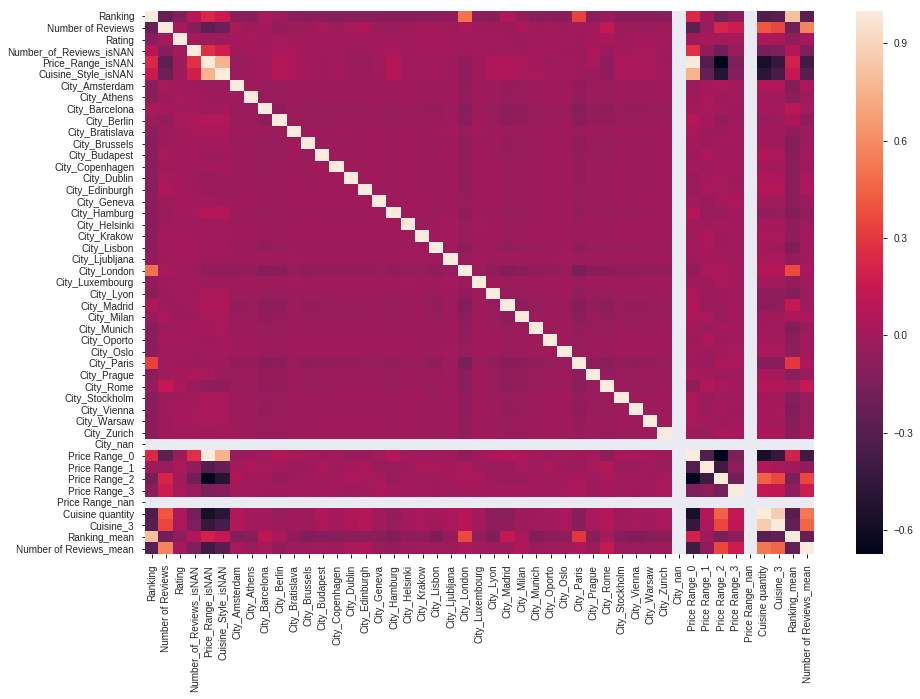

In [69]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [70]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [135]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA','URL_TA'], axis = 1, inplace=True)
    df_output['Price Range'] = df_output['Price Range'].astype(str).apply(lambda x: None if x.strip() == '' else x)
    df_output['Price Range'] = df_output['Price Range'].astype(str).apply(lambda x: x.replace("nan", '0').replace("$$ - $$$", '2').replace('$$$$', '3').replace("$", '1'))
    df_output['Cuisine Style'] = df_output['Cuisine Style'].astype(str).apply(lambda x: None if x.strip() == '' else x)
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda x: x.replace("['", '').replace("', '", ', ').replace("']", ''))
    df_output['Reviews'] = df_output['Reviews'].astype(str).apply(lambda x: None if x.strip() == '' else x)
    df_output['Reviews'] = df_output['Reviews'].apply(lambda x: x.replace('[', '').replace(']', '').replace("'", ''))
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'].fillna(0, inplace=True)
    df_output['Reviews'].fillna('|', inplace=True)
    df_output['Cuisine Style'].fillna('Other', inplace=True)
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=['City', 'Price Range'], dummy_na=True)
    df_output['Cuisine quantity'] = df_output['Cuisine Style'].apply(lambda x: len(x.split(',')))
    #df_output['Cuisine_3'] = df_output['Cuisine quantity']>3
    df_output['Ranking_mean'] = df_output['Ranking']>data['Ranking'].mean()
    df_output['Number of Reviews_mean'] = df_output['Number of Reviews']>data['Number of Reviews'].mean()
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

#### Запускаем и проверяем что получилось

In [136]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Number of Reviews,sample,Rating,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,...,City_Zurich,City_nan,Price Range_0,Price Range_1,Price Range_2,Price Range_3,Price Range_nan,Cuisine quantity,Ranking_mean,Number of Reviews_mean
38676,1773.0,43.0,1,4.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,False,False
29522,11785.0,22.0,1,3.5,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,True,False
48168,1061.0,192.0,1,4.5,0,0,0,0,0,0,...,0,0,0,0,1,0,0,5,False,True
934,509.0,147.0,0,0.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,4,False,True
24798,13503.0,2.0,1,2.5,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,True,False
44321,1412.0,4.0,1,4.5,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,False,False
46576,12477.0,0.0,1,4.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,True,False
43341,3081.0,271.0,1,4.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,5,False,True
41463,6023.0,207.0,1,3.0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,7,True,True
47242,429.0,117.0,1,4.0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,3,False,False


In [137]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 44 columns):
Ranking                   50000 non-null float64
Number of Reviews         50000 non-null float64
sample                    50000 non-null int64
Rating                    50000 non-null float64
City_Amsterdam            50000 non-null uint8
City_Athens               50000 non-null uint8
City_Barcelona            50000 non-null uint8
City_Berlin               50000 non-null uint8
City_Bratislava           50000 non-null uint8
City_Brussels             50000 non-null uint8
City_Budapest             50000 non-null uint8
City_Copenhagen           50000 non-null uint8
City_Dublin               50000 non-null uint8
City_Edinburgh            50000 non-null uint8
City_Geneva               50000 non-null uint8
City_Hamburg              50000 non-null uint8
City_Helsinki             50000 non-null uint8
City_Krakow               50000 non-null uint8
City_Lisbon               50000 non-nul

In [138]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [139]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [140]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 43), (40000, 43), (40000, 42), (32000, 42), (8000, 42))

# Model

In [141]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [142]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [143]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [144]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21119312499999998


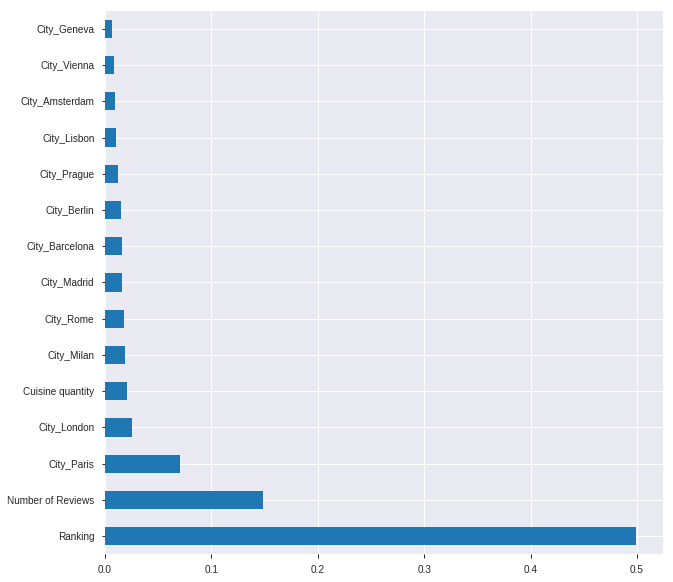

In [145]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission

In [146]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,...,City_Zurich,City_nan,Price Range_0,Price Range_1,Price Range_2,Price Range_3,Price Range_nan,Cuisine quantity,Ranking_mean,Number of Reviews_mean
2803,9810.0,6.0,0.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,True,False
2425,6116.0,17.0,0.0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,True,False
4910,5511.0,3.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,True,False
859,1970.0,65.0,0.0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,False,False
9272,2518.0,6.0,0.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,False,False
383,1211.0,674.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,3,False,True
6830,7.0,317.0,0.0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,8,False,True
2510,53.0,233.0,0.0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,3,False,True
2209,3694.0,74.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,4,True,False
1805,2691.0,131.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,False,True


In [147]:
test_data = test_data.drop(['Rating'], axis=1)

In [148]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [149]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [150]:
predict_submission

array([3.025, 4.315, 4.49 , ..., 3.02 , 4.5  , 4.275])

In [151]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.025
1,id_1,4.315
2,id_2,4.490
3,id_3,4.175
4,id_4,4.450
5,id_5,4.625
6,id_6,2.200
7,id_7,2.715
8,id_8,4.110
9,id_9,4.765


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
